# E_9 Chest X-ray  
=============
  
목차  
  
1. 베이스 라인  
2. VGG-16  
3. VGG+GAP  
4. 베이스 라인+tanh  
5. ResNets50

## 1. 베이스 라인  
-------------  

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 20

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [26]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [24]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [11]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [13]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [14]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [15]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [16]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [17]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

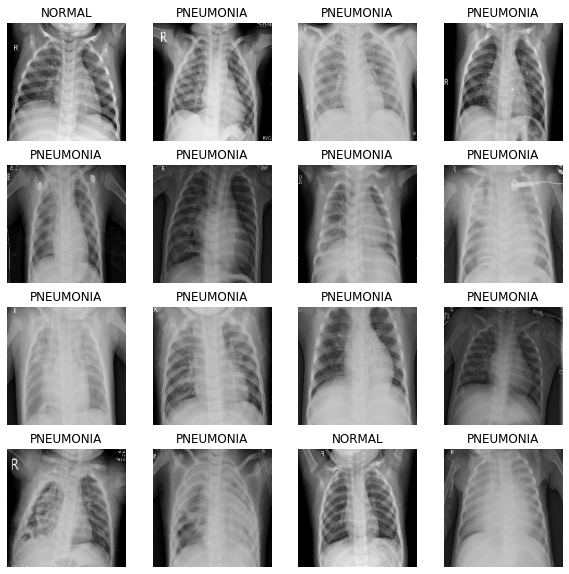

In [18]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [21]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [22]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [23]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [24]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 62s 188ms/step - loss: 0.4097 - accuracy: 0.8113 - precision: 0.9441 - recall: 0.7933 - val_loss: 0.6965 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 187ms/step - loss: 0.2248 - accuracy: 0.9176 - precision: 0.9746 - recall: 0.9132 - val_loss: 1.0555 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1914 - accuracy: 0.9258 - precision: 0.9771 - recall: 0.9217 - val_loss: 0.1976 - val_accuracy: 0.8981 - val_precision: 0.8792 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 49s 190ms/step - loss: 0.1807 - accuracy: 0.9315 - precision: 0.9753 - recall: 0.9313 - val_loss: 0.0656 - val_accuracy: 0.9779 - val_precision: 0.9831 - val_recall: 0.9869
Epoch 5/25
261/261 [==============================] - 51s 196ms/step - loss: 0.1683 - accura

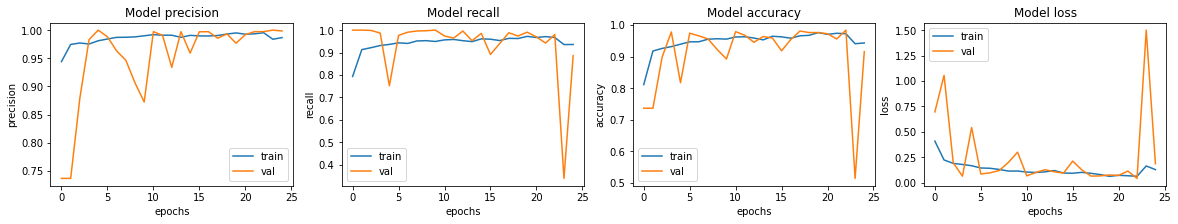

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [26]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 111ms/step - loss: 0.4352 - accuracy: 0.8670 - precision: 0.8753 - recall: 0.9179
Loss: 0.4351646304130554,
Accuracy: 0.8669871687889099,
Precision: 0.8753056526184082,
Recall: 0.9179487228393555


#### 베이스라인 결과  
-------------  
  
특별히 손댄 것 없이 실행했던 모델에서 Accuracy가 0.86이 나오게 됐다. 루브릭 지표를 우연치 않게 넘기게 되어 만족스러움.  
그렇지만 다른 모델을 사용해보고 싶은 마음이 생겨서 다양한 모델을 시험해 보도록 하겠다.

## 2. VGG-16  
------------------

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 2
EPOCHS = 20

print(ROOT_PATH)

/aiffel/aiffel


In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
show = list(train_list_ds.as_numpy_iterator())[:10]
show

[b'/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg',
 b'/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person346_virus_709.jpeg',
 b'/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1746_bacteria_4585.jpeg',
 b'/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person548_bacteria_2297.jpeg',
 b'/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0955-0001.jpeg',
 b'/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1571_bacteria_4108.jpeg',
 b'/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0579-0001.jpeg',
 b'/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person976_bacteria_2901.jpeg',
 b'/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0516-0001.jpeg',
 b'/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0699-0001.jpeg']

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [8]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [9]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [10]:
for image, label in train_ds.take(10):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  False


In [11]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [12]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [13]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

def VGG_16model():
    img_input = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(img_input)
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    x = layers.Conv2D(
      128, (3, 3), activation='relu', padding='same', name='block2conv1')(x)
    x = layers.Conv2D(
      128, (3, 3), activation='relu', padding='same', name='block2conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3conv1')(x)
    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3conv2')(x)
    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3pool')(x)

    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5conv1')(x)
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5conv2')(x)
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5pool')(x)

    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(4096, activation='relu', name='fc1')(x)
    x = layers.Dense(4096, activation='relu', name='fc2')(x)

    classes=1
    x = layers.Dense(classes, activation='softmax', name='predictions')(x) 
    model = keras.Model(name="VGG-16", inputs=img_input, outputs=x)

    return model

In [21]:
model = VGG_16model()

METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
model.summary()

Model: "VGG-16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2conv1 (Conv2D)         (None, 90, 90, 128)       73856     
_________________________________________________________________
block2conv2 (Conv2D)         (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0    

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
2092/2092 [==============================] - 199s 91ms/step - loss: 0.7048 - accuracy: 0.7438 - precision: 0.7438 - recall: 1.0000 - val_loss: 0.6872 - val_accuracy: 0.7352 - val_precision: 0.7352 - val_recall: 1.0000
Epoch 2/20
2092/2092 [==============================] - 190s 91ms/step - loss: 0.6934 - accuracy: 0.7438 - precision: 0.7438 - recall: 1.0000 - val_loss: 0.6923 - val_accuracy: 0.7352 - val_precision: 0.7352 - val_recall: 1.0000
Epoch 3/20
2092/2092 [==============================] - 190s 91ms/step - loss: 0.6932 - accuracy: 0.7440 - precision: 0.7440 - recall: 1.0000 - val_loss: 0.6934 - val_accuracy: 0.7352 - val_precision: 0.7352 - val_recall: 1.0000
Epoch 4/20
2092/2092 [==============================] - 190s 91ms/step - loss: 0.6934 - accuracy: 0.7438 - precision: 0.7438 - recall: 1.0000 - val_loss: 0.6949 - val_accuracy: 0.7361 - val_precision: 0.7361 - val_recall: 1.0000
Epoch 5/20
2092/2092 [==============================] - 190s 91ms/step - loss: 0.693

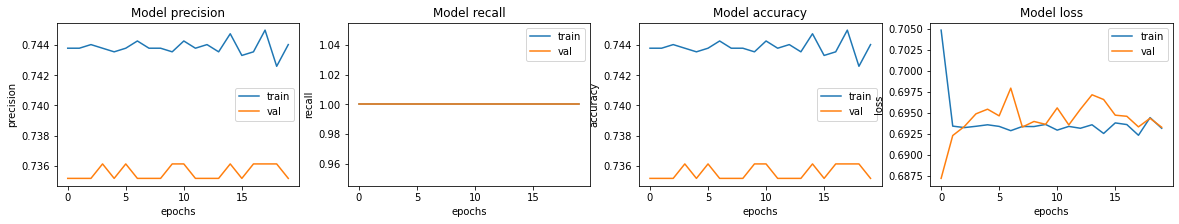

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

312/312 [==============================] - 5s 17ms/step - loss: 0.6932 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6932235360145569,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


#### VGG-16 모델 결과
----  
정말이지 나를 굉장히 힘들게 했던 녀석이였다. 파라미터수가 엄청 많아서 OOM이 빵빵 터져나왔고, **언동님**에게 조언을 구해 배치사이즈를 줄여서 해결해서 간신히 결과를 볼 수 있게 되었다. 그렇지만..
모델을 사용하였을 때 recall값이 1이 나오는 상황이 생겼다. 몇번이고 재시도를 해보았으나 꾸준하게 recall은 1만 보여주는 모델이였다. 그저 폐만 보이면 폐렴이라고 하는 녀석이 되버린 이유를 알지 못해서 한참동안 왜 이런결과를 보여주는 것인지 고민해본 결과, Maxpooling의 횟수가 많아 데이터의 모든 값이 흰색에 가까운 값을 가지게 되어 이런 현상이 발생하게 된 것이 아닐까 하는 생각이 들었고, Globalaveragepooling을 사용해보는 것이 어떻겠냐는 아이디어를 **선아님**👍과 **언동님**이 주셔서 시도해보기로 했다.

## 3. VGG+GAP
----

In [22]:
from tensorflow import keras
from tensorflow.keras import layers
BATCH_SIZE = 16
EPOCHS = 20

def VGG_GAPmodel():
    img_input = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(img_input)
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)

    x = layers.Conv2D(
      128, (3, 3), activation='relu', padding='same', name='block2conv1')(x)
    x = layers.Conv2D(
      128, (3, 3), activation='relu', padding='same', name='block2conv2')(x)

    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3conv1')(x)
    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3conv2')(x)
    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3conv3')(x)


    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5conv1')(x)
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5conv2')(x)
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5conv3')(x)
    x =layers.GlobalAveragePooling2D()(x)



    classes=1
    x = layers.Dense(classes, activation='sigmoid', name='predictions')(x) 
    model = keras.Model(name="VGG_GAP", inputs=img_input, outputs=x)

    return model

In [23]:
model = VGG_GAPmodel()

METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
model.summary()

Model: "VGG_GAP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block2conv1 (Conv2D)         (None, 180, 180, 128)     73856     
_________________________________________________________________
block2conv2 (Conv2D)         (None, 180, 180, 128)     147584    
_________________________________________________________________
block3conv1 (Conv2D)         (None, 180, 180, 256)     295168    
_________________________________________________________________
block3conv2 (Conv2D)         (None, 180, 180, 256)     5900

In [24]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
261/261 [==============================] - 123s 439ms/step - loss: 3.6290 - accuracy: 0.5115 - precision: 0.7519 - recall: 0.5141 - val_loss: 0.6950 - val_accuracy: 0.2462 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
261/261 [==============================] - 116s 445ms/step - loss: 0.6921 - accuracy: 0.2548 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6947 - val_accuracy: 0.2923 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
261/261 [==============================] - 117s 449ms/step - loss: 0.6785 - accuracy: 0.5881 - precision: 0.7486 - recall: 0.6902 - val_loss: 0.6916 - val_accuracy: 0.7615 - val_precision: 0.7615 - val_recall: 1.0000
Epoch 4/20
261/261 [==============================] - 118s 451ms/step - loss: 0.7158 - accuracy: 0.3352 - precision: 0.6667 - recall: 0.1493 - val_loss: 0.6960 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
261/261 [==============================] - 11

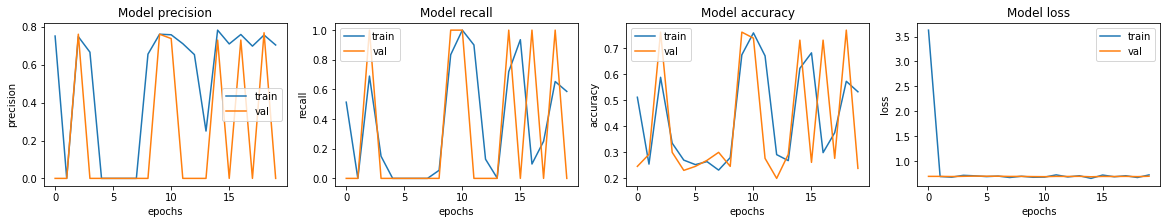

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [26]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

312/312 [==============================] - 49s 156ms/step - loss: 0.6951 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss: 0.6951078772544861,
Accuracy: 0.375,
Precision: 0.0,
Recall: 0.0


In [28]:
def VGG_GAPmodel():
    img_input = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(img_input)
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)

    x = layers.Conv2D(
      128, (3, 3), activation='relu', padding='same', name='block2conv1')(x)
    x = layers.Conv2D(
      128, (3, 3), activation='relu', padding='same', name='block2conv2')(x)

    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3conv1')(x)
    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3conv2')(x)
    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3conv3')(x)


    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5conv1')(x)
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5conv2')(x)
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5conv3')(x)
    layers.GlobalAveragePooling2D()



    classes=1
    x = layers.Dense(classes, activation='softmax', name='predictions')(x) 
    model = keras.Model(name="VGG_GAP", inputs=img_input, outputs=x)

    return model

In [29]:
model2 = VGG_GAPmodel()

METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
model.summary()

Model: "VGG_GAP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block2conv1 (Conv2D)         (None, 180, 180, 128)     73856     
_________________________________________________________________
block2conv2 (Conv2D)         (None, 180, 180, 128)     147584    
_________________________________________________________________
block3conv1 (Conv2D)         (None, 180, 180, 256)     295168    
_________________________________________________________________
block3conv2 (Conv2D)         (None, 180, 180, 256)     5900

In [30]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
261/261 [==============================] - 127s 455ms/step - loss: 0.6888 - accuracy: 0.2510 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6955 - val_accuracy: 0.2231 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
261/261 [==============================] - 120s 461ms/step - loss: 0.6836 - accuracy: 0.2759 - precision: 0.7000 - recall: 0.0711 - val_loss: 0.6929 - val_accuracy: 0.7692 - val_precision: 0.7692 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 121s 462ms/step - loss: 0.6836 - accuracy: 0.7548 - precision: 0.7548 - recall: 1.0000 - val_loss: 0.6905 - val_accuracy: 0.7154 - val_precision: 0.7154 - val_recall: 1.0000
Epoch 4/20
261/261 [==============================] - 121s 462ms/step - loss: 0.7074 - accuracy: 0.6169 - precision: 0.7228 - recall: 0.7684 - val_loss: 0.6938 - val_accuracy: 0.2462 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
261/261 [==============================] - 120s 462ms

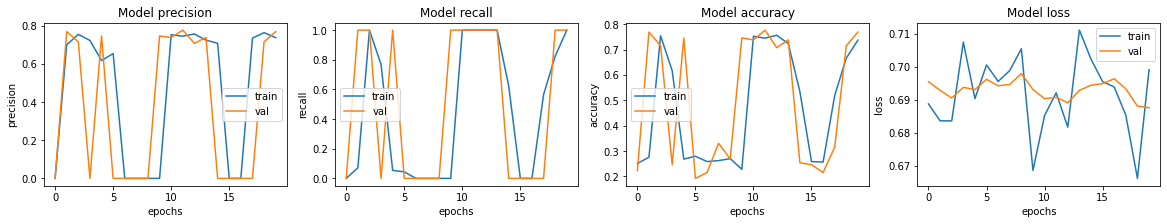

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [32]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

312/312 [==============================] - 50s 159ms/step - loss: 0.6906 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6905947327613831,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


#### VGG+GAP 결과
----  
드디어 이번에는 recall값이 1에만 머무르는 상황은 벗어나게 되었으나 0,1 오가며 나타내는 결과를 얻었다. 마지막 레이어의 활성함수가 sigmoid가 아닌 softmax를 쓰면 혹시나 다른 결과를 보여주지 않을까하는 생각에 softmax로도 해봤지만, 그런거 없이 극단적으로 움직이는 그래프만 보여준다. 내 모델의 recall값은 이진법이 되어버렸다.. 여기서 생각해보게 된 것은 레이어가 너무 깊어서 gradient 소실이 일어나는걸까?? 라는 의문이였다. 그러면서 베이스 라인의 모델을 보니 배치정규화도 해주고 드롭아웃도 같이 사용되었었고, 내가 구성한 모델에는 두 가지 모두 하지 않았었다. 잘못되었음을 깨달은 순간이었지만 되돌릴 수가 없었던게 아쉽다.

## 4. 베이스 모델 + tanh  
----  


In [9]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [10]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [39]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=1) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = (img -127.5) / 127.5
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [40]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [41]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 1)
Label:  False


In [42]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [43]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [60]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(4, activation='tanh'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [61]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [62]:
with tf.device('/GPU:0'):
    model_tanh = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_tanh.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [63]:
with tf.device('/GPU:0'):
    history = model_tanh.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
2092/2092 [==============================] - 59s 25ms/step - loss: 0.7227 - accuracy: 0.5038 - precision: 0.7495 - recall: 0.5000 - val_loss: 0.7575 - val_accuracy: 0.2639 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
2092/2092 [==============================] - 52s 25ms/step - loss: 0.7049 - accuracy: 0.4847 - precision: 0.7306 - recall: 0.4870 - val_loss: 0.7228 - val_accuracy: 0.2648 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
2092/2092 [==============================] - 52s 25ms/step - loss: 0.6982 - accuracy: 0.4902 - precision: 0.7434 - recall: 0.4804 - val_loss: 0.7675 - val_accuracy: 0.2648 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
2092/2092 [==============================] - 51s 25ms/step - loss: 0.6956 - accuracy: 0.5189 - precision: 0.7519 - recall: 0.5276 - val_loss: 0.7455 - val_accuracy: 0.2648 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
2092/2092 [==============================] - 

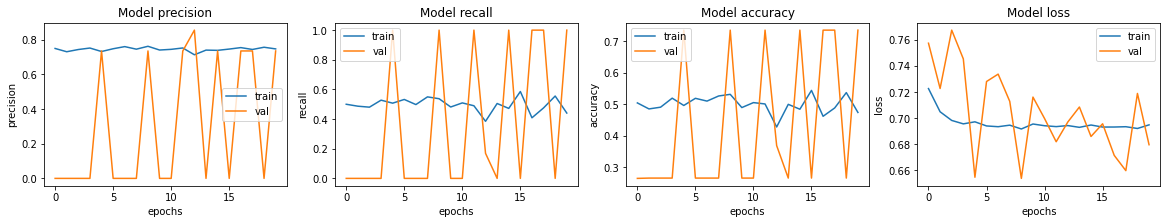

In [64]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [66]:
loss, accuracy, precision, recall = model_tanh.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

312/312 [==============================] - 4s 11ms/step - loss: 0.6862 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6861655116081238,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


#### 베이스라인 +tanh 결과  
----  
이번엔 데이터를 nomalize하여 데이터의 범위를[-1, 1] 사이로 해서 tanh를 써보고자 하였다.  
(원래 계획은 마지막레이어에서 tanh를 사용하는 것이였으나, predict의 범위가 0과 1사이에 있어야한다는 에러가 발생하여 포기하였음. 지금 생각해보면 로스함수를 변경해보는건 어땠을까 싶기도 함.)  
그리고 기존 베이스라인 모델을 가져와 드롭아웃과 batch nomalization도 사용하였다.  
그럼에도 불구하고 이번 그래프 역시 요동치는 그래프를 얻게 되었다 test 결과는 Recall 1으로  
이번에도~ 세상 모든 폐 사진은 폐렴이라고 말해주는 모델을 만들게 되었다. tanh로 활성화 한 후에 다시 sigmoid를 사용할거였으면 차라리 nomalize를 [0, 1]범위로 하고 tanh를 사용하지 않는게 어땠을까? 하는 생각이 든다.

## 5. ResNets50  
----

In [7]:
BATCH_SIZE = 2
EPOCHS = 30
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [8]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [10]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [11]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [15]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

es = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')
resnet_model = keras.applications.resnet.ResNet50(include_top=False, weights=None, input_tensor=None, input_shape=(180,180,3), pooling='avg', classes=1)
x = keras.layers.Dense(128, activation='relu')(resnet_model.output)
x = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(resnet_model.input, x)

In [17]:
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 186, 186, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 90, 90, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 90, 90, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [18]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
2092/2092 [==============================] - 159s 57ms/step - loss: 0.5565 - accuracy: 0.7522 - precision: 0.9054 - recall: 0.7445 - val_loss: 0.4766 - val_accuracy: 0.7658 - val_precision: 0.8235 - val_recall: 0.8674
Epoch 2/30
2092/2092 [==============================] - 117s 56ms/step - loss: 0.3686 - accuracy: 0.8365 - precision: 0.9480 - recall: 0.8255 - val_loss: 0.3537 - val_accuracy: 0.8614 - val_precision: 0.8492 - val_recall: 0.9870
Epoch 3/30
2092/2092 [==============================] - 117s 56ms/step - loss: 0.3076 - accuracy: 0.8745 - precision: 0.9668 - recall: 0.8610 - val_loss: 0.3108 - val_accuracy: 0.8633 - val_precision: 0.9603 - val_recall: 0.8492
Epoch 4/30
2092/2092 [==============================] - 117s 56ms/step - loss: 0.2878 - accuracy: 0.8757 - precision: 0.9655 - recall: 0.8637 - val_loss: 0.3676 - val_accuracy: 0.8155 - val_precision: 0.9898 - val_recall: 0.7568
Epoch 5/30
2092/2092 [==============================] - 117s 56ms/step - loss: 0.240

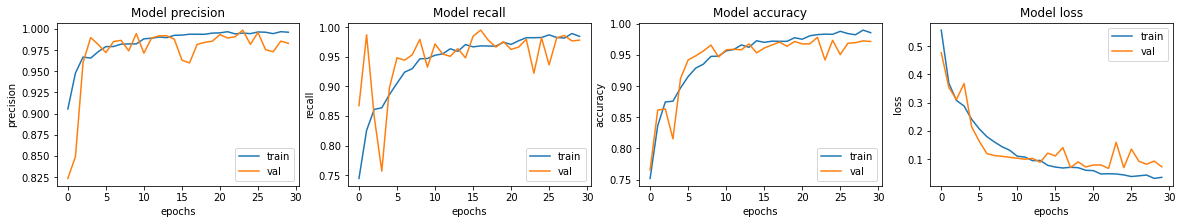

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [20]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

312/312 [==============================] - 7s 22ms/step - loss: 1.3726 - accuracy: 0.7692 - precision: 0.7330 - recall: 0.9923
Loss: 1.3726035356521606,
Accuracy: 0.7692307829856873,
Precision: 0.7329545617103577,
Recall: 0.9923076629638672


#### ResNets50 결과  
----  
  
이번엔 keras에 application으로 공개되어 있는 ResNets50 모델을 사용해보았다. 처음 계획엔 없었으나 **선아님**의 오류해결을 함께 해보고자 시작하게 되었다. 사실 VGG-16모델도 application으로 공개된 모델이 있었으나, 사용이 미숙하여 공개된 모델을 사용하지 못하고 직접 레이어를 만들었던 것인데, 이번 익스를 진행하면서 stackoverflow에 자주 가게 되고, 같은 고민을 했던 사람들과 그에 대한 해결책을 주는 많은 이들의 댓글을 보며 해결책을 찾다보니 ResNets은 이것저것 뒤적거리며 모델 사용 해결방법을 얻게 되었다.  사용했던 모델 중 유일하게 학습 되고 있는 모양을 보이는 그래프를 얻을 수 있었으며, 에폭을 최대 40까지 해봤는데 40이 최고의 accuracy를 보여줬고, 그 다음이 현재 있는 30, 그리고 early stopping을 사용했던 사례 순이다. overfitting을 걱정했지만 아직 제대로 학습되지 않은 상태가 아닐까 하는 유추를 하였고, 에폭을 100까지 돌려보고 싶었으나, 30에폭 조차 1시간이 걸려서 제출시간이 한시간 남은 지금은 해볼 수 없는 상황이라 개인적으로 도전해보도록 할 예정이다. 학습만 잘 된다면 accuracy 0.9이상도 노려볼 수 있지 않을까? 라는 생각을 하게 되었고, 더 많은 공개모델들을 사용해보고 싶어졌다. 

## 회고  
----  
딥ML시간과 노드에서 배웠던 imagenets에서 우수한 성적을 거둔 모델들을 사용해보고 싶은 마음이 들어 진행했던 익스로 모델사용에 너무 치중해서 데이터 전처리를 nomalize밖에 해보지 못했던 것이 아쉽고, 성능이 더 뛰어난 Inception이나 NASNet 같은 모델들을 사용해보지 못한 것이 아쉬움이 남았다.  
여러 시도를 해보면서 모델 구축과 사용법에 대해 많은 공부가 되었으나, Recall 1이 나오는 이유를 기울기 소실이라고 유추만 한 채 확인해보지 못한 것 또한 아쉬움으로 남는다. VGG모델에서 fc7계층의 컨텍스트벡터를 볼 수 있다고 하였는데 실제로 시각화하여 확인 해보지 못했던 것 또한 아쉽게 느껴진다.
